In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation



In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Concatenate
from sklearn.preprocessing import LabelEncoder

source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
train_dir = os.path.join(source_folder, "train")
test_dir = os.path.join(source_folder, "test")

IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

# Load VGG19 for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False

def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)

# Encoding labels as integers (ASD=0, TD=1)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Extracting features using VGG19
train_features = vgg19_model.predict(train_data, batch_size=BATCH_SIZE, verbose=1)
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


# Defining the Inception V4 architecture

def inception_a(x, filters):

    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch2 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch2)

    branch3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch3)

    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch4)

    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output

def inception_b(x, filters):

    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch2 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch2)

    branch3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch3)

    branch4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch4)

    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output

def inception_c(x, filters):

    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch2 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch2)

    branch3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch3)

    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch4)

    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output

# Building the Inception V4 model
input_layer = Input(shape=(7, 7, 512))  # VGG19 output shape (7x7x512)
x = inception_a(input_layer, [64, 128, 128, 32, 32, 32])
x = inception_b(x, [128, 256, 256, 64, 64, 64])
x = inception_c(x, [256, 512, 512, 128, 128, 128])

x = AveragePooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

inception_v4_model = Model(inputs=input_layer, outputs=x)

inception_v4_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model using the training data
inception_v4_model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE,
    epochs=30
)

test_loss, test_acc = inception_v4_model.evaluate(test_features, test_labels)
print(f"Inception V4 Test Accuracy: {test_acc * 100:.2f}%")

# Saving the model
inception_v4_model.save("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v4_with_vgg19_features.h5")
print("Model saved as 'inception_v4_with_vgg19_features.h5'")


Inception V4 Test Accuracy: 94.24%
Model saved as 'inception_v4_with_vgg19_features.h5'


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
Precision: 0.9367
Recall: 0.9610
F1 Score: 0.9487
Confusion Matrix:
[[114  10]
 [  6 148]]


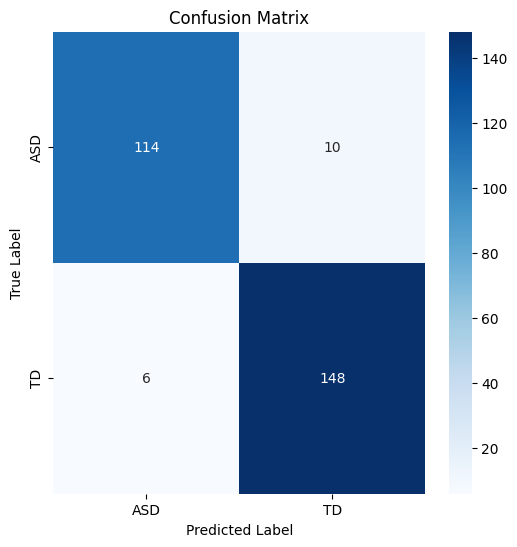

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")

IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

# Loading VGG19 for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v4_with_vgg19_features.h5")


predicted_probs = inception_model.predict(test_features, batch_size=BATCH_SIZE)
predicted_labels = (predicted_probs > 0.5).astype(int)

# Computing precision, recall, F1 score, and confusion matrix
precision = precision_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels)
f1 = f1_score(test_labels_encoded, predicted_labels)
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


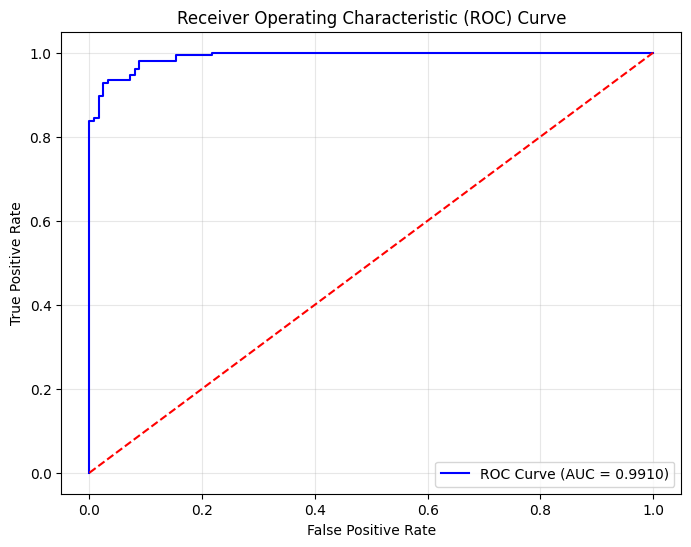

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")


IMG_SIZE = (224, 224)
BATCH_SIZE = 32


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


test_features_reshaped = test_features.reshape(test_features.shape[0], 7, 7, 512)


inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v4_with_vgg19_features.h5")


predicted_probs = inception_model.predict(test_features_reshaped, batch_size=BATCH_SIZE)


fpr, tpr, thresholds = roc_curve(test_labels_encoded, predicted_probs)
roc_auc = auc(fpr, tpr)

# plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
